_model = 'google/vit-large-patch16-224'

Ajustar la Tasa de Aprendizaje para permitir que el modelo aprenda de manera más estable y precisa. Establecer learning_rate a un valor más bajo.

Implementar Regularización Adicional : Añadir Weight Decay para penalizar pesos grandes y prevenir el sobreajuste.Configurar el parámetro weight_decay en TrainingArguments a 0.01

In [1]:
# Parámetros
_model = 'google/vit-large-patch16-224'
_checkpoint = None
_output = 'VT_12'  # Ruta para guardar el modelo

# Ruta al dataset (actualizada)
_dataset_dir = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/images_4categories_balanced/masas'

# Ruta para guardar el dataset con splits
_dataset_split_path = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/images_4categories_balanced/masas_split2'

# Establecer a None para forzar la creación de splits
_dataset_split = None

_batch_size = 16
_learning_rate = 1e-4
_epochs = 10  # Número de epochs para entrenar

# DropOut
_dp_clasificador = 0.3
_dp_hidden_layer = 0.2
_dp_attention_layer = 0.2

num_layers_to_unfreeze = 5  # Número de capas del encoder a descongelar para fine-tuning

# Importaciones
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from collections import Counter
from datasets import load_dataset, DatasetDict, load_from_disk

from transformers import AutoImageProcessor, ViTForImageClassification
from transformers import Trainer, TrainingArguments

import evaluate
import matplotlib.pyplot as plt

from PIL import Image
import os

# Funciones auxiliares
def show_samples(ds, rows, cols):
    """Muestra una cuadrícula de imágenes del dataset."""
    samples = ds.shuffle(seed=42).select(np.arange(rows * cols))  # Selecciona imágenes al azar
    fig = plt.figure(figsize=(cols * 4, rows * 4))
    for i in range(rows * cols):
        img = samples[i]['image']
        label = samples[i]['label']
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Verificar la estructura del directorio
if not os.path.isdir(_dataset_dir):
    print(f"El directorio {_dataset_dir} no existe.")
else:
    print(f"Contenido de {_dataset_dir}:")
    for entry in os.listdir(_dataset_dir):
        entry_path = os.path.join(_dataset_dir, entry)
        if os.path.isdir(entry_path):
            num_files = len([f for f in os.listdir(entry_path) if f.lower().endswith('.png')])
            print(f"  - {entry}/: {num_files} archivos .png")
        else:
            print(f"  - {entry} (No es una carpeta)")

# Verificar integridad de algunas imágenes
def verificar_imagenes(dataset_dir, subcarpetas, num_imagenes=5):
    for subcarpeta in subcarpetas:
        subcarpeta_path = os.path.join(dataset_dir, subcarpeta)
        if not os.path.isdir(subcarpeta_path):
            print(f"La subcarpeta '{subcarpeta}' no existe en '{dataset_dir}'.")
            continue
        imagenes = [f for f in os.listdir(subcarpeta_path) if f.lower().endswith('.png')]
        print(f"\nVerificando imágenes en '{subcarpeta}/':")
        for img_name in imagenes[:num_imagenes]:
            img_path = os.path.join(subcarpeta_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Verifica la integridad de la imagen
                print(f"  - {img_name}: OK")
            except Exception as e:
                print(f"  - {img_name}: Corrupta o inaccesible ({e})")

# Lista de subcarpetas esperadas
subcarpetas = ['benigno', 'maligno', 'sospechoso']

# Ejecutar la verificación
verificar_imagenes(_dataset_dir, subcarpetas, num_imagenes=5)

# Carga de datos
try:
    if _dataset_split is None:
        # Cargar el dataset usando 'imagefolder'
        dataset = load_dataset('imagefolder', data_dir=_dataset_dir)
        # Dividir el dataset en train (80%) y test (20%)
        split_dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)
        # Dividir el test en validation (10%) y test (10%)
        eval_dataset = split_dataset['test'].train_test_split(test_size=0.5, seed=42)
        
        # Recombinación de los splits 
        final_dataset = DatasetDict({
            'train': split_dataset['train'],
            'validation': eval_dataset['train'],
            'test': eval_dataset['test']
        })
        # Guardar el dataset dividido
        final_dataset.save_to_disk(_dataset_split_path)
        print("Dataset dividido y guardado.")
    else:
        # Intentar cargar el dataset previamente guardado
        dataset = load_from_disk(_dataset_split_path)
        print("Dataset cargado desde la ruta de splits.")
        final_dataset = dataset
except Exception as e:
    print(f"Error al cargar el dataset: {e}")
    print("Intentando cargar el dataset original y crear los splits.")
    dataset = load_dataset('imagefolder', data_dir=_dataset_dir)
    # Dividir el dataset en train (80%) y test (20%)
    split_dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)
    # Dividir el test en validation (10%) y test (10%)
    eval_dataset = split_dataset['test'].train_test_split(test_size=0.5, seed=42)
    
    # Recombinación de los splits 
    final_dataset = DatasetDict({
        'train': split_dataset['train'],
        'validation': eval_dataset['train'],
        'test': eval_dataset['test']
    })
    # Guardar el dataset dividido
    final_dataset.save_to_disk(_dataset_split_path)
    print("Dataset dividido y guardado.")

print(final_dataset)

# Revisión de categorías
labels = final_dataset['train'].features['label'].names
print(f"Número de categorías: {len(labels)}")
print(f"Categorías: {labels}")

label2id = {c: idx for idx, c in enumerate(labels)}
id2label = {idx: c for idx, c in enumerate(labels)}

# Muestra de ejemplos (opcional)
# show_samples(final_dataset['train'], rows=3, cols=5)  # Descomenta para visualizar ejemplos

# Número de imágenes por clases en cada split
print('Número de imágenes por clases en cada split')
clases_split = pd.DataFrame(columns=['split'] + labels)
for key in final_dataset:
    split = pd.DataFrame(final_dataset[key])
    num = split['label'].value_counts().sort_index()
    # Asegurarse de que todas las clases estén presentes
    counts = [num.get(i, 0) for i in range(len(labels))]
    clases_split.loc[len(clases_split)] = [key] + counts
print(clases_split)

# Preprocesamiento de las imágenes
processor = AutoImageProcessor.from_pretrained(_model, use_fast=True)
print(processor)

def transforms(batch):
    """Transformaciones aplicadas a cada batch del dataset."""
    # Convertir imágenes a RGB
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    # Procesar imágenes
    inputs = processor(batch['image'], return_tensors='pt')
    # Añadir etiquetas
    inputs['labels'] = batch['label']
    return inputs

processed_dataset = final_dataset.with_transform(transforms)

# Data Collation
def collate_fn(batch):
    """Función de colación para agrupar los datos en batches."""
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

# Métricas de evaluación
accuracy = evaluate.load('accuracy')
precision = evaluate.load('precision')
recall = evaluate.load('recall')
f1 = evaluate.load('f1')

def compute_metrics(eval_preds):
    """Calcula las métricas de evaluación."""
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=1)

    # Debugging: Conteo de etiquetas y predicciones
    print("Conteo de etiquetas reales:", Counter(labels))
    print("Conteo de predicciones:", Counter(predictions))
    
    # Cálculo de precisión por clase
    precision_per_class = precision.compute(predictions=predictions, references=labels, average=None)
    print("Precisión por clase:", precision_per_class)

    # Cálculo de métricas globales
    accuracy_score = accuracy.compute(predictions=predictions, references=labels)['accuracy']
    precision_score = precision.compute(predictions=predictions, references=labels, average='macro')['precision']
    recall_score = recall.compute(predictions=predictions, references=labels, average='macro')['recall']
    f1_score = f1.compute(predictions=predictions, references=labels, average='macro')['f1']
    
    return {
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'f1': f1_score
    }


/Volumes/m2/Memoria/Code/PMM/modulo/venv3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Contenido de /Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/processed/subset_datos/images_4categories_balanced/masas:
  - sospechoso/: 834 archivos .png
  - benigno/: 834 archivos .png
  - maligno/: 834 archivos .png

Verificando imágenes en 'benigno/':
  - cfdda9d0be846ba0716fcf18ae3abf70_0.png: OK
  - ea46f4834d92e77afe1da27757b0678b_0_aug_extra.png: OK
  - b75d6c0a7d9ca2545b994559f1327422_0_aug_extra.png: OK
  - a251204836e86f9eca510afa7a79d450_0_aug_extra.png: OK
  - 4d63c40fb038d24bb1ff6da3912272c7_2.png: OK

Verificando imágenes en 'maligno/':
  - 54716121c39ea4f99484a063f81a719e_0_aug_1.png: OK
  - b5ae06a11207fe5bd03c4ff05dca25f9_0_aug_extra.png: OK
  - b73d4e04b69d52ba6f350cc77da54f95_0_aug_2.png: OK
  - 96eb9c4bdf059f2f8da825bfc0a3ba69_0_aug_3.png: OK
  - da860c7c1030662471437b1c9d32ed81_1_aug_6.png: OK

Verificando imágenes en 'sospechoso/':
  - b5b4758224e6a66a587182fcdc5f1f1d_0.png: OK
  - 36f1d0a7b515cef7eab05bdbfde38094_0.png: OK
  - ea8790b418b754139457d48e

Saving the dataset (1/1 shards): 100%|██████████| 251/251 [00:00<00:00, 3492.26 examples/s]


Dataset dividido y guardado.
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2001
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 250
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 251
    })
})
Número de categorías: 3
Categorías: ['benigno', 'maligno', 'sospechoso']
Número de imágenes por clases en cada split
        split  benigno  maligno  sospechoso
0       train      672      678         651
1  validation       76       80          94
2        test       86       76          89
ViTImageProcessorFast {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



In [2]:
# ==========================
# Celda 2: Entrenamiento del Modelo 
# ==========================

# Clase personalizada que añade dropout antes de la capa final de clasificación
class CustomViTForImageClassification(ViTForImageClassification):
    def __init__(self, config):
        super().__init__(config)
        
        # Dropout adicional antes de la capa final
        self.additional_dropout = nn.Dropout(_dp_clasificador)  # Dropout antes del clasificador
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, pixel_values, labels=None):
        outputs = self.vit(pixel_values)  # Salida del modelo ViT
        
        # Usar el primer token [CLS] de la salida
        pooled_output = outputs.last_hidden_state[:, 0]  # [CLS] está en la posición 0
        
        # Aplicar dropout adicional antes de la clasificación
        pooled_output = self.additional_dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            # Asegurarse de que las etiquetas sean tipo long (para clasificación)
            class_weights = torch.tensor([1.0, 1.0, 1.0], dtype=torch.float32).to(self.device)  # Clases balanceadas
            loss_fn = nn.CrossEntropyLoss(weight=class_weights)
            loss = loss_fn(logits, labels)
        
        return (loss, logits) if loss is not None else logits

# Actualización de la tasa de aprendizaje
_learning_rate = 5e-5  # Reducida de 1e-4 a 5e-5

# Cargar y configurar el modelo
model = CustomViTForImageClassification.from_pretrained(
    _model,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    hidden_dropout_prob=_dp_hidden_layer,  # Dropout en las capas internas del modelo
    attention_probs_dropout_prob=_dp_attention_layer,  # Dropout en las capas de atención
    ignore_mismatched_sizes=True  # Ignorar discrepancias en tamaños de pesos
)

print(model)

# Congelar todas las capas, excepto el clasificador y el dropout adicional
for name, p in model.named_parameters():
    if not (name.startswith('classifier') or name.startswith('additional_dropout')):
        p.requires_grad = False

num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")
# Ejemplo: num_params = 303,304,707 | trainable_params = 3,075

# Descongelar capas del encoder para fine-tuning
# Obtener el número total de capas en el encoder
num_total_layers = len(list(model.vit.encoder.layer))  # Debería ser 24 para ViT-Large
print(f"Número total de capas en el encoder: {num_total_layers}")

if num_layers_to_unfreeze is not None:
    # Calcular el índice a partir del cual descongelar
    unfreeze_from = num_total_layers - num_layers_to_unfreeze
    print(f"Descongelando desde la capa {unfreeze_from} hasta la capa {num_total_layers - 1}")
    
    # Iterar sobre todas las capas del encoder
    for idx, layer in enumerate(model.vit.encoder.layer):
        if idx >= unfreeze_from:
            # Descongelar esta capa
            for param in layer.parameters():
                param.requires_grad = True
        else:
            # Congelar esta capa
            for param in layer.parameters():
                param.requires_grad = False

# Actualizar el conteo de parámetros entrenables después de descongelar
num_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Después de descongelar las últimas {num_layers_to_unfreeze} capas:")
print(f"Total de parámetros: {num_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")

# Configuración de los Argumentos de Entrenamiento con ajuste de tasa de aprendizaje y weight decay
training_args = TrainingArguments(
    output_dir=_output,
    per_device_train_batch_size=_batch_size,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=_epochs,  # Número de epochs a entrenar
    learning_rate=_learning_rate,  # Tasa de aprendizaje ajustada a 5e-5
    weight_decay=0.01,  # Implementación de Weight Decay para regularización
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

# Configuración del Trainer con los nuevos argumentos
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor
)

# Verificar disponibilidad de MPS (Metal Performance Shaders para MacOS)
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS no está disponible porque la instalación actual de PyTorch no fue construida con MPS habilitado.")
    else:
        print("MPS no está disponible porque la versión actual de MacOS no es 12.3+ y/o no tienes un dispositivo habilitado para MPS en esta máquina.")
else:
    mps_device = torch.device("mps")
    print("MPS habilitado")

# Iniciar el entrenamiento
trainer.train()


Some weights of CustomViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([3, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.011000,0.909221,0.508000,0.479495,0.531588,0.469415
2,0.875900,0.880166,0.556000,0.544858,0.574253,0.550089
3,0.835200,0.891454,0.524000,0.516596,0.536609,0.516766
4,0.747600,0.858570,0.556000,0.548600,0.571953,0.552930
5,0.706200,0.949313,0.520000,0.511741,0.535764,0.506640
6,0.695400,0.881215,0.572000,0.564113,0.589679,0.562879
7,0.624200,0.901242,0.580000,0.572964,0.597793,0.569209
8,0.583400,0.894954,0.584000,0.577650,0.601997,0.575238
9,0.572000,0.904938,0.560000,0.556961,0.570059,0.560899
10,0.541400,0.936054,0.568000,0.561482,0.582153,0.563838


Conteo de etiquetas reales: Counter({np.int64(2): 94, np.int64(1): 80, np.int64(0): 76})
Conteo de predicciones: Counter({np.int64(1): 136, np.int64(0): 82, np.int64(2): 32})
Precisión por clase: {'precision': array([0.54878049, 0.51470588, 0.375     ])}
Conteo de etiquetas reales: Counter({np.int64(2): 94, np.int64(1): 80, np.int64(0): 76})
Conteo de predicciones: Counter({np.int64(0): 100, np.int64(1): 88, np.int64(2): 62})
Precisión por clase: {'precision': array([0.54      , 0.65909091, 0.43548387])}
Conteo de etiquetas reales: Counter({np.int64(2): 94, np.int64(1): 80, np.int64(0): 76})
Conteo de predicciones: Counter({np.int64(1): 112, np.int64(0): 71, np.int64(2): 67})
Precisión por clase: {'precision': array([0.56338028, 0.55357143, 0.43283582])}
Conteo de etiquetas reales: Counter({np.int64(2): 94, np.int64(1): 80, np.int64(0): 76})
Conteo de predicciones: Counter({np.int64(0): 97, np.int64(1): 87, np.int64(2): 66})
Precisión por clase: {'precision': array([0.53608247, 0.65517

TrainOutput(global_step=1260, training_loss=0.7050074607606918, metrics={'train_runtime': 3753.0531, 'train_samples_per_second': 5.332, 'train_steps_per_second': 0.336, 'total_flos': 5.481441463291638e+18, 'train_loss': 0.7050074607606918, 'epoch': 10.0})

Modelo guardado en: VT_12


Conteo de etiquetas reales: Counter({np.int64(2): 89, np.int64(0): 86, np.int64(1): 76})
Conteo de predicciones: Counter({np.int64(1): 96, np.int64(0): 91, np.int64(2): 64})
Precisión por clase: {'precision': array([0.58241758, 0.61458333, 0.4375    ])}
Resultados de evaluación en el conjunto de test:
{'eval_loss': 0.8505429625511169, 'eval_accuracy': 0.5577689243027888, 'eval_precision': 0.5448336385836386, 'eval_recall': 0.5690672002713866, 'eval_f1': 0.5503098800068357, 'eval_runtime': 27.3282, 'eval_samples_per_second': 9.185, 'eval_steps_per_second': 1.171, 'epoch': 10.0}
Conteo de etiquetas reales: Counter({np.int64(2): 89, np.int64(0): 86, np.int64(1): 76})
Conteo de predicciones: Counter({np.int64(1): 96, np.int64(0): 91, np.int64(2): 64})
Precisión por clase: {'precision': array([0.58241758, 0.61458333, 0.4375    ])}


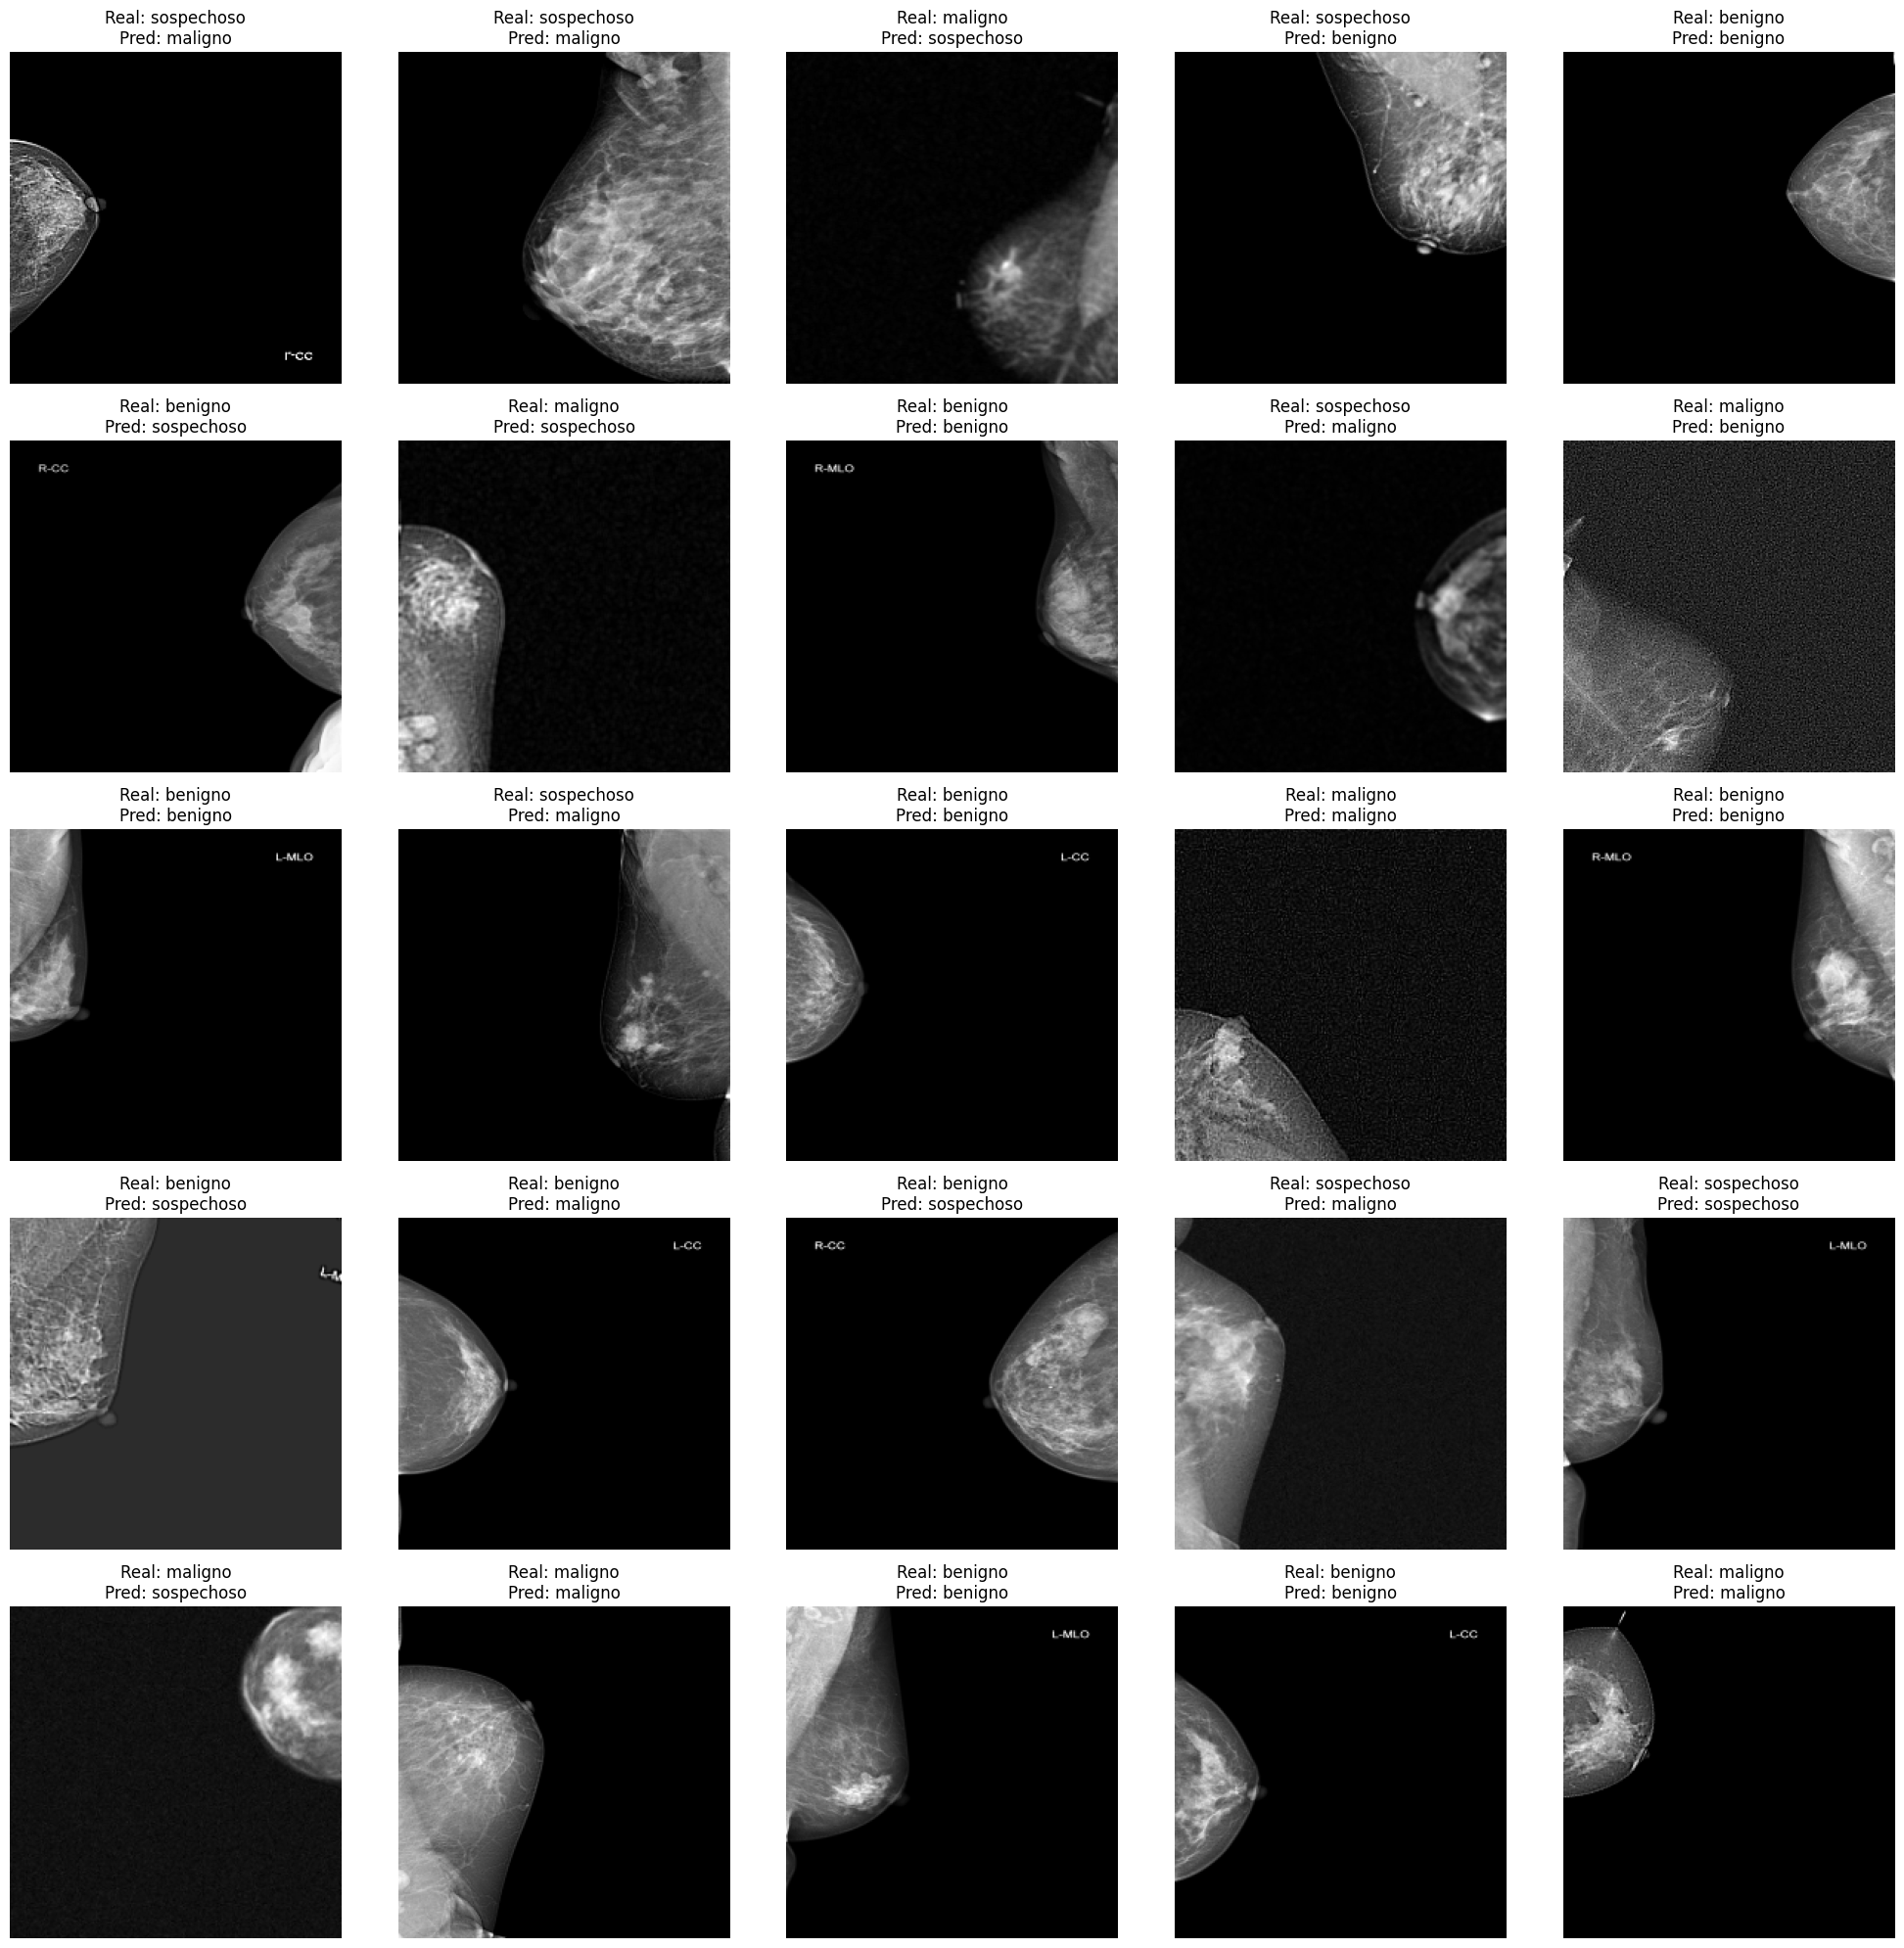

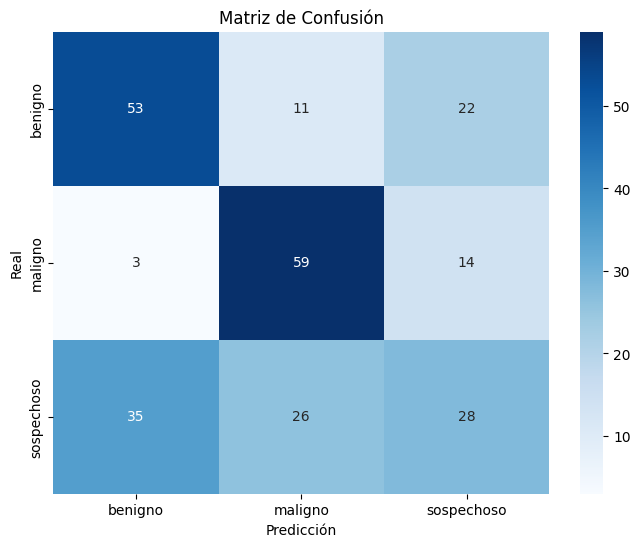

In [3]:
# ==========================
# Celda 3: Evaluación del Modelo
# ==========================

# Guardar el modelo entrenado
trainer.save_model()
print("Modelo guardado en:", _output)

# Evaluación del modelo en el conjunto de test
evaluation_results = trainer.evaluate(processed_dataset['test'])
print("Resultados de evaluación en el conjunto de test:")
print(evaluation_results)

# Inferencia en conjunto de test
samples = final_dataset['test']
processed_samples = samples.with_transform(transforms)
predictions = trainer.predict(processed_samples).predictions.argmax(axis=1)  # Etiquetas predichas

# Función para mostrar predicciones
def show_predictions(rows, cols, samples_, predictions_, id2label_):
    """Muestra una cuadrícula de imágenes con etiquetas reales y predichas."""
    samples_shown = samples_.shuffle(seed=42).select(np.arange(rows * cols))
    fig = plt.figure(figsize=(cols * 4, rows * 4))
    for i in range(rows * cols):
        img = samples_shown[i]['image']
        true_label = id2label_[samples_shown[i]['label']]
        pred_label = id2label_[predictions_[i]]
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Real: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Función para generar matriz de confusión
def confusion_matrix_plot(samples_, predictions_, class_names=None):
    """Genera y muestra una matriz de confusión."""
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    true_labels = [label for label in samples_['label']]
    cm = confusion_matrix(true_labels, predictions_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

# Mostrar algunas predicciones
show_predictions(rows=5, cols=5, samples_=samples, predictions_=predictions, id2label_=id2label)

# Mostrar matriz de confusión
confusion_matrix_plot(samples_=samples, predictions_=predictions, class_names=labels)

# (Opcional) Iterar por más epochs
# Si deseas continuar el entrenamiento, descomenta las siguientes líneas:

# trainer.args.num_train_epochs = 30  # Establecer a 30 epochs
# trainer.train(resume_from_checkpoint=_checkpoint)
# trainer.save_model()
# evaluation_results = trainer.evaluate(processed_dataset['test'])
# print("Resultados de evaluación después de continuar el entrenamiento:")
# print(evaluation_results)
# confusion_matrix_plot(samples_=samples, predictions_=predictions, class_names=labels)
